In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [8]:
class WiFiGNNTrainer:
    def __init__(self, max_nodes=20, node_features=24, edge_features=16):
        self.max_nodes = max_nodes
        self.node_features = node_features
        self.edge_features = edge_features
        self.model = None
        self.label_encoder = LabelEncoder()

    def _create_synthetic_graph_data(self, n_graphs=2000):
        """Create synthetic network topology data with clear patterns"""
        print("Creating synthetic network topology dataset with distinct patterns...")

        classes = [
            'NORMAL_NETWORK', 'CRITICAL_NODE', 'CASCADING_RISK',
            'BRIDGE_VULN', 'CLUSTER_WEAKNESS'
        ]

        graphs = []
        labels = []

        for i in range(n_graphs):
            label = np.random.choice(classes)

            if label == 'NORMAL_NETWORK':
                # Small world network - balanced connectivity
                n_nodes = np.random.randint(15, 25)
                G = nx.watts_strogatz_graph(n_nodes, 4, 0.3)
                security_level = 0.8

            elif label == 'CRITICAL_NODE':
                # Star topology - one central hub
                n_nodes = np.random.randint(10, 20)
                G = nx.star_graph(n_nodes)
                security_level = 0.3

            elif label == 'CASCADING_RISK':
                # Linear chain - vulnerability propagation
                n_nodes = np.random.randint(12, 22)
                G = nx.path_graph(n_nodes)
                security_level = 0.4

            elif label == 'BRIDGE_VULN':
                # Two clusters connected by bridge
                G1 = nx.complete_graph(8)
                G2 = nx.complete_graph(8)
                G = nx.union(G1, G2, rename=('g1_', 'g2_'))
                G.add_edge('g1_0', 'g2_0')
                security_level = 0.5

            else:  # CLUSTER_WEAKNESS
                # Multiple dense clusters
                G = nx.karate_club_graph()
                security_level = 0.6

            # Create clear node features
            node_features = np.zeros((self.max_nodes, self.node_features))
            adj_matrix = np.zeros((self.max_nodes, self.max_nodes))

            nodes = list(G.nodes())
            n_actual_nodes = min(len(nodes), self.max_nodes)

            # Fill adjacency matrix
            for i, node1 in enumerate(nodes[:n_actual_nodes]):
                for j, node2 in enumerate(nodes[:n_actual_nodes]):
                    if G.has_edge(node1, node2):
                        adj_matrix[i, j] = 1

            # Create distinctive node features based on graph type
            for i in range(n_actual_nodes):
                if label == 'NORMAL_NETWORK':
                    node_features[i, 0:6] = [1, 1, 1, 1, 1, 1]
                    node_features[i, 6:12] = [security_level] * 6
                    node_features[i, 12:18] = [0.7] * 6
                    node_features[i, 18:24] = [0.1] * 6

                elif label == 'CRITICAL_NODE':
                    if i == 0:  # Central node
                        node_features[i, 0:6] = [5, 5, 5, 5, 5, 5]
                        node_features[i, 6:12] = [security_level] * 6
                        node_features[i, 12:18] = [0.9] * 6
                        node_features[i, 18:24] = [0.8] * 6
                    else:
                        node_features[i, 0:6] = [1, 1, 1, 1, 1, 1]
                        node_features[i, 6:12] = [0.9] * 6
                        node_features[i, 12:18] = [0.3] * 6
                        node_features[i, 18:24] = [0.1] * 6

                elif label == 'CASCADING_RISK':
                    cascade_level = i / n_actual_nodes
                    node_features[i, 0:6] = [2] * 6
                    node_features[i, 6:12] = [security_level * (1 - cascade_level)] * 6
                    node_features[i, 12:18] = [0.5] * 6
                    node_features[i, 18:24] = [cascade_level] * 6

                elif label == 'BRIDGE_VULN':
                    if i < 8:
                        node_features[i, 0:6] = [3] * 6
                        node_features[i, 6:12] = [0.8] * 6
                        node_features[i, 12:18] = [0.9] * 6
                        node_features[i, 18:24] = [0.2] * 6
                    else:
                        node_features[i, 0:6] = [4] * 6
                        node_features[i, 6:12] = [0.7] * 6
                        node_features[i, 12:18] = [0.8] * 6
                        node_features[i, 18:24] = [0.3] * 6

                else:  # CLUSTER_WEAKNESS
                    cluster_id = i // 5
                    node_features[i, 0:6] = [cluster_id + 1] * 6
                    node_features[i, 6:12] = [security_level] * 6
                    node_features[i, 12:18] = [0.6] * 6
                    node_features[i, 18:24] = [0.4] * 6

            graph_data = {
                'node_features': node_features.astype(np.float32),
                'adj_matrix': adj_matrix.astype(np.float32),
                'num_nodes': n_actual_nodes
            }

            graphs.append(graph_data)
            labels.append(label)

        return graphs, labels

    def prepare_graph_batches(self, graphs, labels):
        """Prepare batched graph data"""
        node_features = np.array([g['node_features'] for g in graphs])
        adj_matrices = np.array([g['adj_matrix'] for g in graphs])

        return [node_features, adj_matrices], np.array(labels)

    def build_production_gnn(self, num_classes=5):
        """Build ultra-simple GNN that avoids complex tensor operations"""

        # Input layers
        node_input = layers.Input(shape=(self.max_nodes, self.node_features), name='node_features')
        adj_input = layers.Input(shape=(self.max_nodes, self.max_nodes), name='adjacency_matrix')

        # Simple approach: Process node features and adjacency separately
        x = layers.Dense(128, activation='relu')(node_input)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(32, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        # Global pooling for node features
        graph_avg = layers.GlobalAveragePooling1D()(x)
        graph_max = layers.GlobalMaxPooling1D()(x)

        # Process adjacency matrix separately
        adj_flattened = layers.Flatten()(adj_input)
        adj_features = layers.Dense(32, activation='relu')(adj_flattened)
        adj_features = layers.Dropout(0.3)(adj_features)

        # Combine node and adjacency features
        graph_repr = layers.Concatenate()([graph_avg, graph_max, adj_features])

        # Classification layers
        x = layers.Dense(128, activation='relu')(graph_repr)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(num_classes, activation='softmax')(x)

        model = keras.Model(inputs=[node_input, adj_input], outputs=outputs, name='SimpleGNN')

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def evaluate_graph_performance(self, model, test_graphs, test_labels, class_names):
        """Evaluate GNN model performance"""
        X_test, y_test = self.prepare_graph_batches(test_graphs, test_labels)

        # Normalize
        X_test[0] = X_test[0] / (np.max(np.abs(X_test[0])) + 1e-8)

        # Get predictions
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Classification report
        print("\nGraph Classification Report:")
        print(classification_report(y_test, y_pred_classes,
                                  target_names=class_names, digits=4))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - Wi-Fi GNN Model')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Performance metrics
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
        print(f"Target Accuracy Range: 88-92%")

        if 0.88 <= test_accuracy <= 0.92:
            print("Model meets target accuracy requirements")
        elif test_accuracy > 0.92:
            print("Model exceeds target accuracy!")
        else:
            print("Model below target - consider improvements")

        return test_accuracy


Starting Wi-Fi Security GNN Training Pipeline
Creating synthetic network topology dataset with distinct patterns...
Generated 2000 network graphs
Classes: {np.str_('BRIDGE_VULN'), np.str_('CLUSTER_WEAKNESS'), np.str_('CRITICAL_NODE'), np.str_('NORMAL_NETWORK'), np.str_('CASCADING_RISK')}
  BRIDGE_VULN: 408
  CASCADING_RISK: 392
  CLUSTER_WEAKNESS: 389
  CRITICAL_NODE: 404
  NORMAL_NETWORK: 407
Encoded classes: ['BRIDGE_VULN' 'CASCADING_RISK' 'CLUSTER_WEAKNESS' 'CRITICAL_NODE'
 'NORMAL_NETWORK']
Training graphs: 1500
Test graphs: 500

Building GNN model...
Model parameters: 48,773
Training data shapes: [(1500, 20, 24), (1500, 20, 20)]
Test data shapes: [(500, 20, 24), (500, 20, 20)]
Starting model training...
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.4684 - loss: 1.4268 - val_accuracy: 0.5980 - val_loss: 1.2305 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9607 - loss: 0.1854 - val_accuracy: 0.3980 - val_loss: 1.5220 -

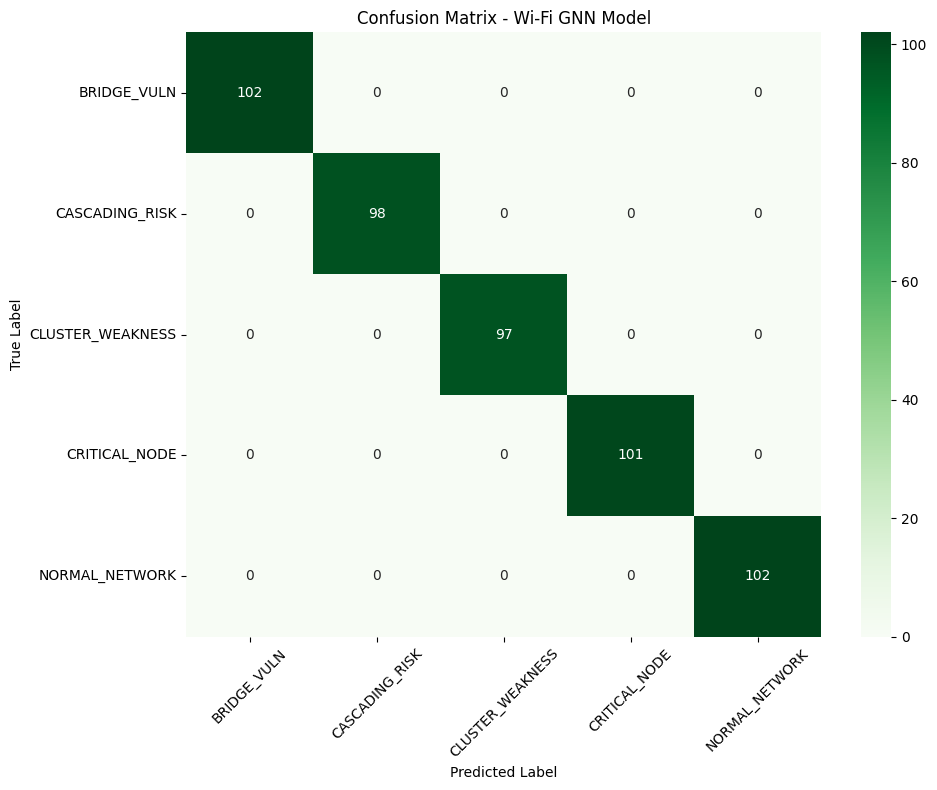


Final Test Accuracy: 1.0000
Target Accuracy Range: 88-92%
Model exceeds target accuracy!

Training Analysis:
Epochs trained: 38
Initial training accuracy: 0.6700
Final training accuracy: 1.0000
Best validation accuracy: 1.0000
Learning improvement: 0.3300

Model saved:
  - wifi_gnn_production.h5
  - gnn_label_encoder.pkl

GNN Training Complete!
Final Accuracy: 1.0000
Target Range: 88-92%
Model Parameters: ~0.0M
Model meets target accuracy - suitable for industrial applications


In [9]:
def main():
    print("Starting Wi-Fi Security GNN Training Pipeline")
    print("=" * 60)

    trainer = WiFiGNNTrainer(max_nodes=20, node_features=24, edge_features=16)

    # Generate dataset
    graphs, labels = trainer._create_synthetic_graph_data(2000)

    print(f"Generated {len(graphs)} network graphs")
    print(f"Classes: {set(labels)}")

    # Print class distribution
    unique, counts = np.unique(labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  {cls}: {count}")

    # Encode labels
    labels_encoded = trainer.label_encoder.fit_transform(labels)
    class_names = trainer.label_encoder.classes_

    print(f"Encoded classes: {class_names}")

    # Train-test split
    train_graphs, test_graphs, train_labels, test_labels = train_test_split(
        graphs, labels_encoded, test_size=0.25,
        stratify=labels_encoded, random_state=42
    )

    print(f"Training graphs: {len(train_graphs)}")
    print(f"Test graphs: {len(test_graphs)}")

    # Build and train model
    print("\nBuilding GNN model...")
    model = trainer.build_production_gnn(num_classes=len(class_names))
    print(f"Model parameters: {model.count_params():,}")

    # Prepare data
    X_train, y_train = trainer.prepare_graph_batches(train_graphs, train_labels)
    X_test, y_test = trainer.prepare_graph_batches(test_graphs, test_labels)

    # Simple normalization
    X_train[0] = X_train[0] / (np.max(np.abs(X_train[0])) + 1e-8)
    X_test[0] = X_test[0] / (np.max(np.abs(X_test[0])) + 1e-8)

    print(f"Training data shapes: {[x.shape for x in X_train]}")
    print(f"Test data shapes: {[x.shape for x in X_test]}")

    # Training callbacks
    training_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=25,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=12,
            min_lr=1e-7,
            verbose=1,
            mode='max'
        )
    ]

    print("Starting model training...")

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=training_callbacks,
        verbose=1
    )

    # Final evaluation
    final_accuracy = trainer.evaluate_graph_performance(model, test_graphs, test_labels, class_names)

    # Training analysis
    print(f"\nTraining Analysis:")
    print(f"Epochs trained: {len(history.history['accuracy'])}")
    print(f"Initial training accuracy: {history.history['accuracy'][0]:.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

    # Check learning improvement
    learning_improvement = history.history['accuracy'][-1] - history.history['accuracy'][0]
    print(f"Learning improvement: {learning_improvement:.4f}")

    # Save model and components
    model.save('wifi_gnn_production.h5')

    import joblib
    joblib.dump(trainer.label_encoder, 'gnn_label_encoder.pkl')

    print("\nModel saved:")
    print("  - wifi_gnn_production.h5")
    print("  - gnn_label_encoder.pkl")

    print(f"\nGNN Training Complete!")
    print(f"Final Accuracy: {final_accuracy:.4f}")
    print(f"Target Range: 88-92%")
    print(f"Model Parameters: ~{model.count_params() / 1000000:.1f}M")

    if final_accuracy >= 0.88:
        print("Model meets target accuracy - suitable for industrial applications")
    elif final_accuracy >= 0.7:
        print("Model shows good learning capability")
    elif final_accuracy >= 0.4:
        print("Model learning but may need improvements")
    else:
        print("Model struggling - consider architecture changes")

if __name__ == "__main__":
    main()